In [2]:
import numpy as np
from data_loader2 import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Dense
from keras.models import Model, load_model
from keras.utils import plot_model, multi_gpu_model

Using TensorFlow backend.


In [2]:
# data_file = "/datax/yzhang/training_data/training_data_chunk_0.pkl"
# data = LoadModRecData(data_file, .9, .1, 0.)

# test_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
# testdata = LoadModRecData(test_file, 0.1, 0., 1.)



data = []
for i in range(14):
    data_file = "/datax/yzhang/training_data/training_data_chunk_" + str(i) + ".pkl"
    data.append(LoadModRecData(data_file, 1., 0., 0.))
    

    
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, 1., 0., 0.)





[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
number_of_samples_in_instance = data[0].instance_shape[1]
data.modTypes

AttributeError: 'list' object has no attribute 'modTypes'

In [6]:
# # for each modulation type, inspect some instances of data
# for modType in data.modTypes[:]:
#     min_SNR = -10
#     max_SNR = 10
#     snr_step = 4

#     # get random snr within valid range
#     snrValue = random.randrange(min_SNR, max_SNR, snr_step)

#     # get a collection of signals
#     collection_of_instances = data.dataCube[modType, snrValue]

#     # get the complex samples for a specific instance within the collection
#     cdata, index = get_complex_samples_for_instance(collection_of_instances)
#     print(cdata.shape,index)

#     # setup inspect
#     sample_rate = number_of_samples_in_instance
#     Ts = 1.0 / sample_rate
#     t = np.arange(0, len(cdata[0])) * Ts
    
#     plt.figure()
#     plt.title(modType)
#     plt.plot(cdata.squeeze().real)
#     plt.plot(cdata.squeeze().imag)
#     # inspect signal
# plt.show()    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

In [7]:
def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=8, padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=4, padding='same', activation='relu')(tower_3)
    tower_5 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(filters=fs[3], kernel_size=2, padding='same', activation='relu')(tower_5)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same', activation='relu')(tower_4)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
#     num_layers = [2,4,10,4]
    num_layers = [1,2,2,1]
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64, kernel_size=[2,7], strides=[2,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, fs=[32,64,32,64,64])
#     x = GlobalAveragePooling1D()(x)
#     x = Conv2D(filters=64, kernel_size=[1,1], padding='same', activation='relu')(x) # optional dim reduction

    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out
in_shp = (2, 1024)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 1024, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 512, 64)   960         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 1, 256, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
plot_model(model, to_file='model.png', show_shapes = True)


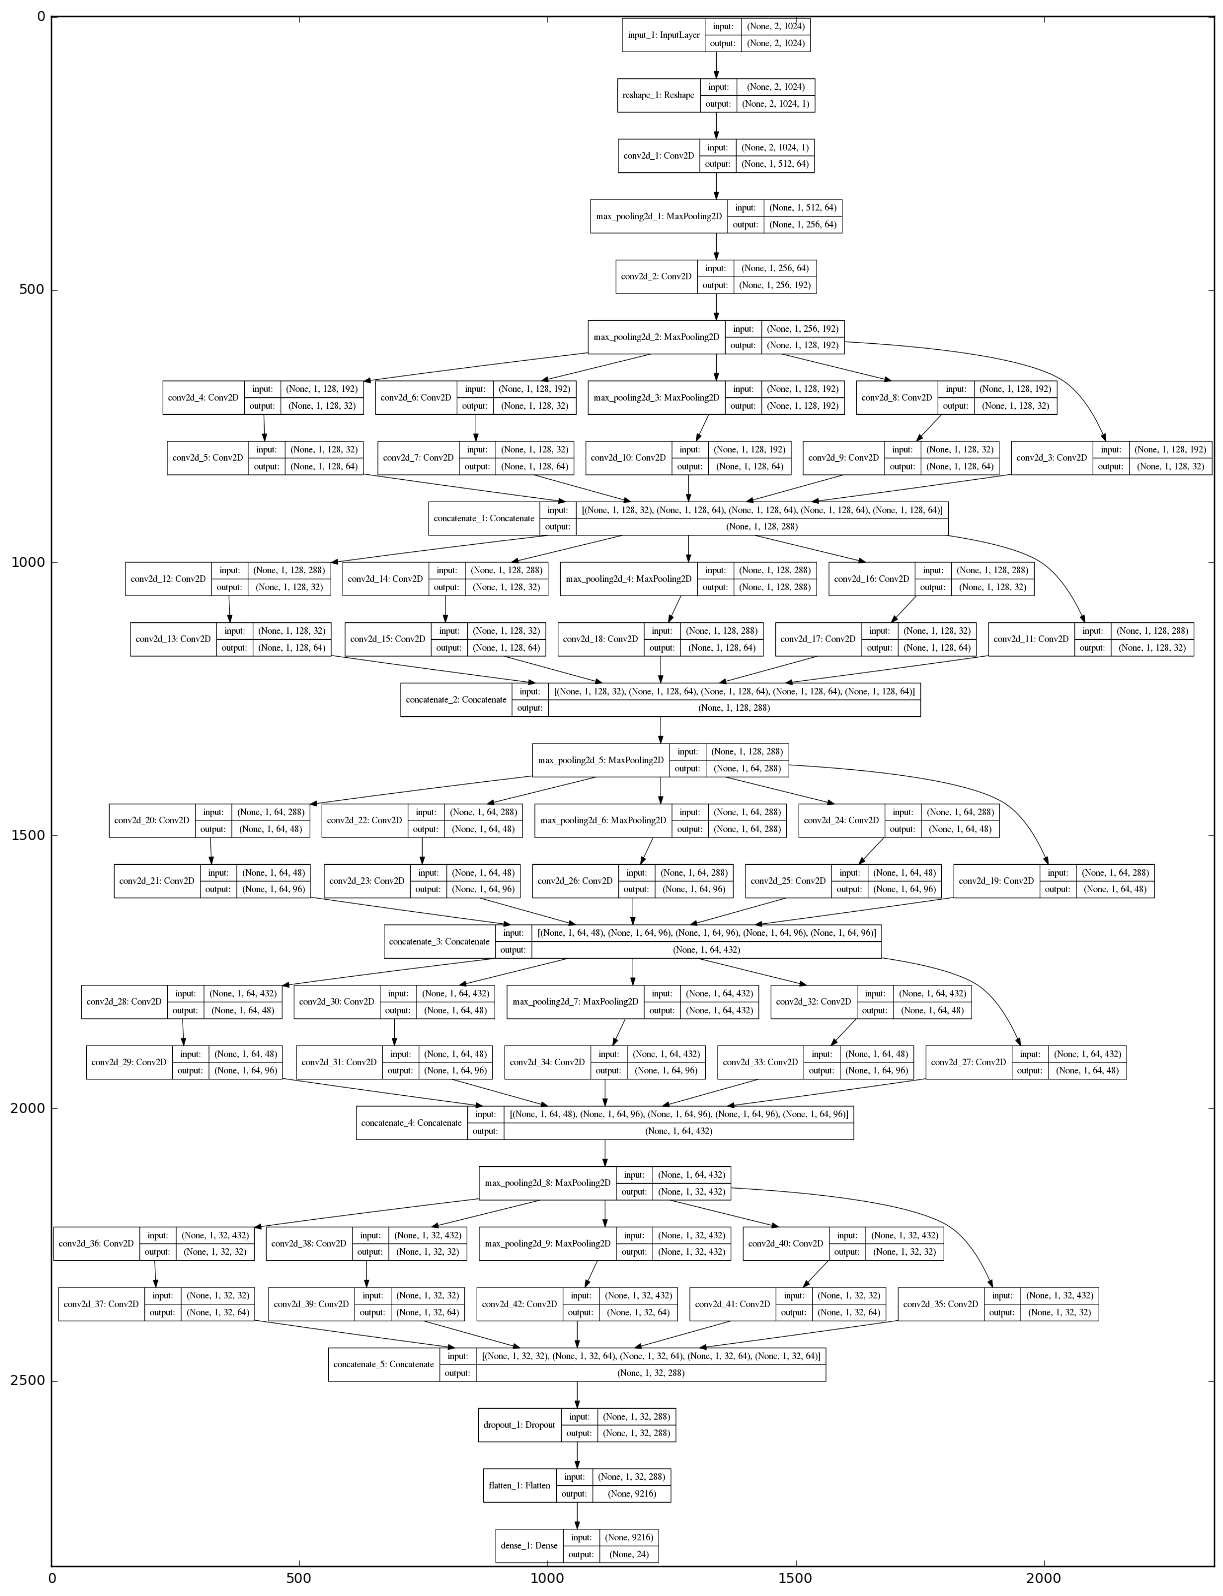

In [9]:
# Uncomment to visualize architecture
plot_model(model, to_file='model.png', show_shapes = True)

figure(figsize = (15,20))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [13]:


train_batch_size, number_of_epochs = 512, 2000        

val_batches = testdata.batch_iter(testdata.train_idx, train_batch_size, number_of_epochs, use_shuffle=False)
vsteps = testdata.train_idx.size//train_batch_size


generators = []
tsteps = 0
for d in data:
    generators.append(d.batch_iter(d.train_idx, train_batch_size, number_of_epochs, use_shuffle=False))
    tsteps += d.train_idx.size

tsteps = tsteps//train_batch_size 

def train_batches():
    while True:
        batches_x, batches_y = [], []

        for gen in generators:
            batch_x, batch_y = next(gen)
            batches_x.append(batch_x)
            batches_y.append(batch_y)
            
        batches_x = np.concatenate(batches_x)
        batches_y = np.concatenate(batches_y)
        
        idx = np.random.permutation(batches_x.shape[0])
        
        batches_x = batches_x[idx]
        batches_y = batches_y[idx]
        
        for i in range(len(generators)):
            beg = i * train_batch_size
            end = beg + train_batch_size
            yield batches_x[beg:end], batches_y[beg:end]
        

train_batches = train_batches()


In [ ]:
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'
# train_batch_size, number_of_epochs = 256, 40
# tsteps = data.train_idx.size//train_batch_size
# vsteps = data.val_idx.size//train_batch_size
# train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
# val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)
# model.load_weights(filepath)
history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
     callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss'    , verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5    , verbose=0, mode='auto')
     ]) 
model.save('mod_classifier22.h5')  



print("Done")

/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, validation_steps=562, callbacks=[<keras.ca..., epochs=2000, validation_data=<generator..., steps_per_epoch=7875)`


Epoch 1/2000


In [ ]:
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, 0., 0., 1.)


model_path = "mod_classifier20.h5"
model = load_model(model_path)


classes  ['16PSK' '2FSK_5KHz' '2FSK_75KHz' '8PSK' 'AM_DSB' 'AM_SSB' 'APSK16_c34'
 'APSK32_c34' 'BPSK' 'CPFSK_5KHz' 'CPFSK_75KHz' 'FM_NB' 'FM_WB'
 'GFSK_5KHz' 'GFSK_75KHz' 'GMSK' 'MSK' 'NOISE' 'OQPSK' 'PI4QPSK' 'QAM16'
 'QAM32' 'QAM64' 'QPSK']
SNR -10 Overall Accuracy:  0.46710416666666665 Out of 96000
SNR -6 Overall Accuracy:  0.6883020833333333 Out of 96000
SNR -2 Overall Accuracy:  0.8402395833333334 Out of 96000
SNR 2 Overall Accuracy:  0.8921354166666666 Out of 96000
SNR 6 Overall Accuracy:  0.91134375 Out of 96000
SNR 10 Overall Accuracy:  0.9180416666666666 Out of 48000


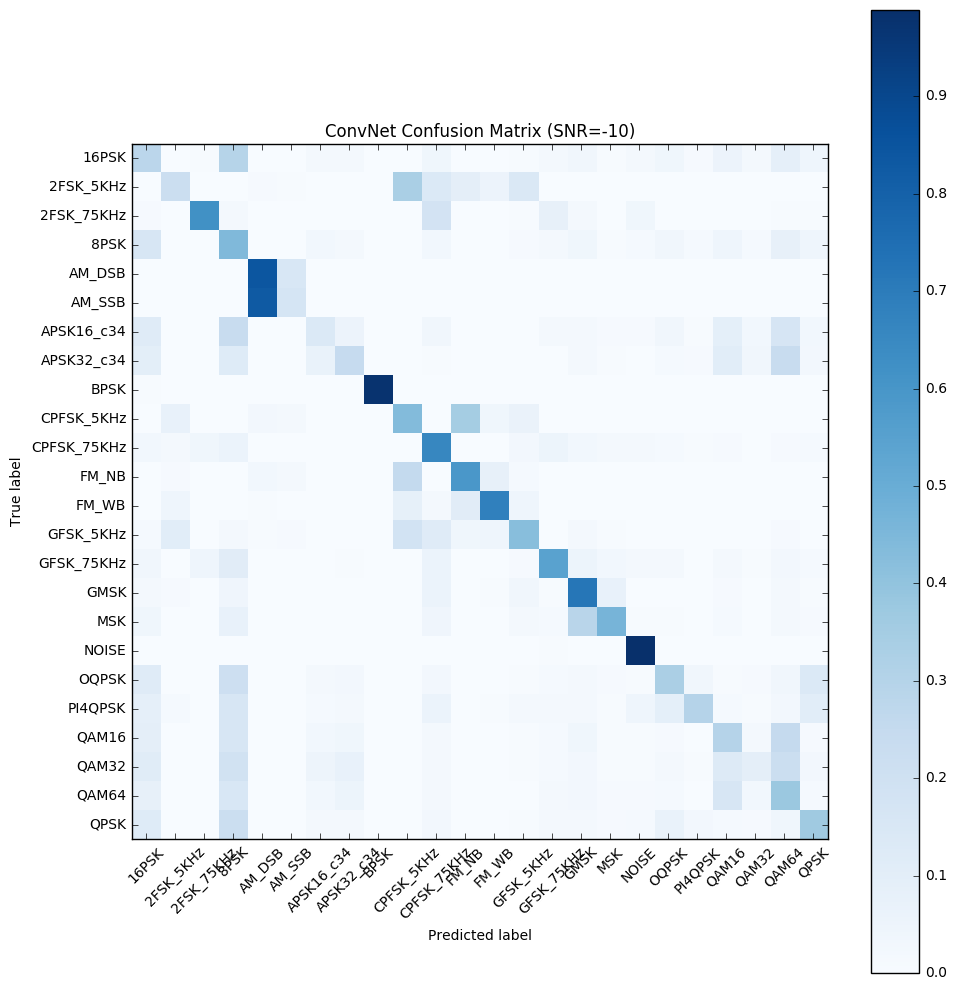

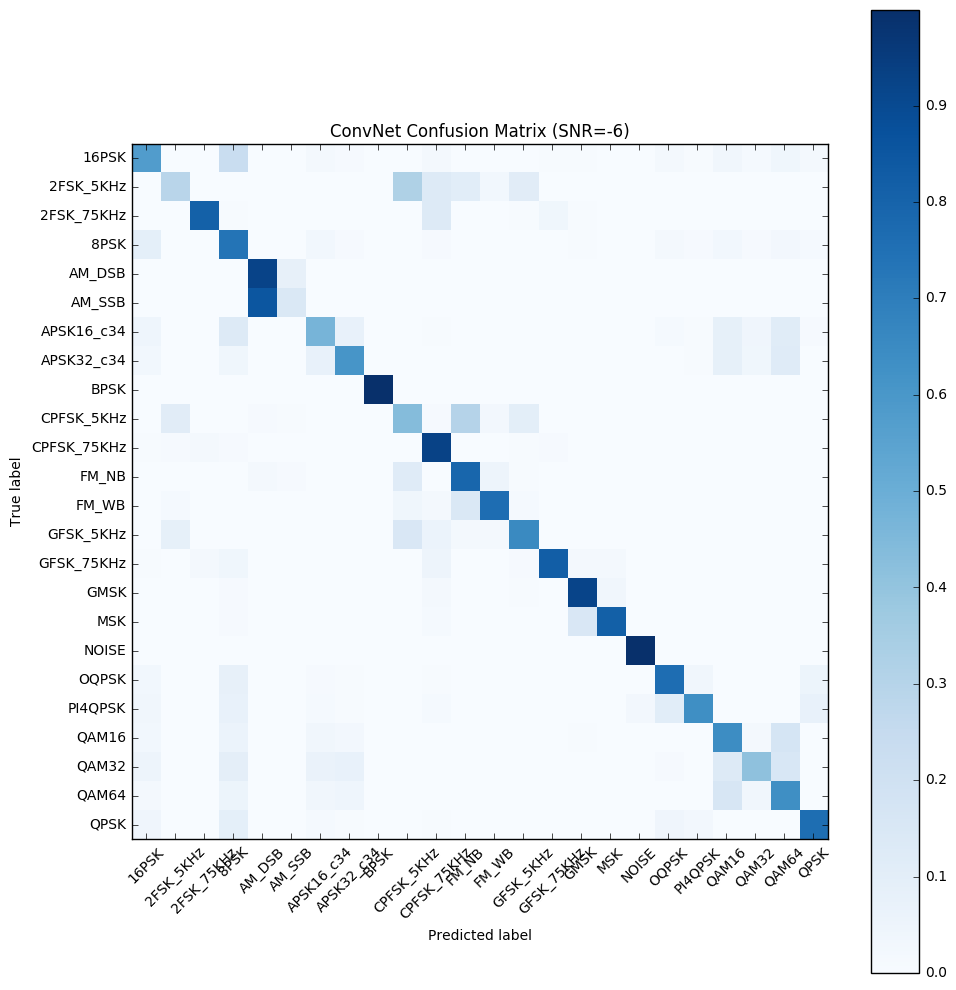

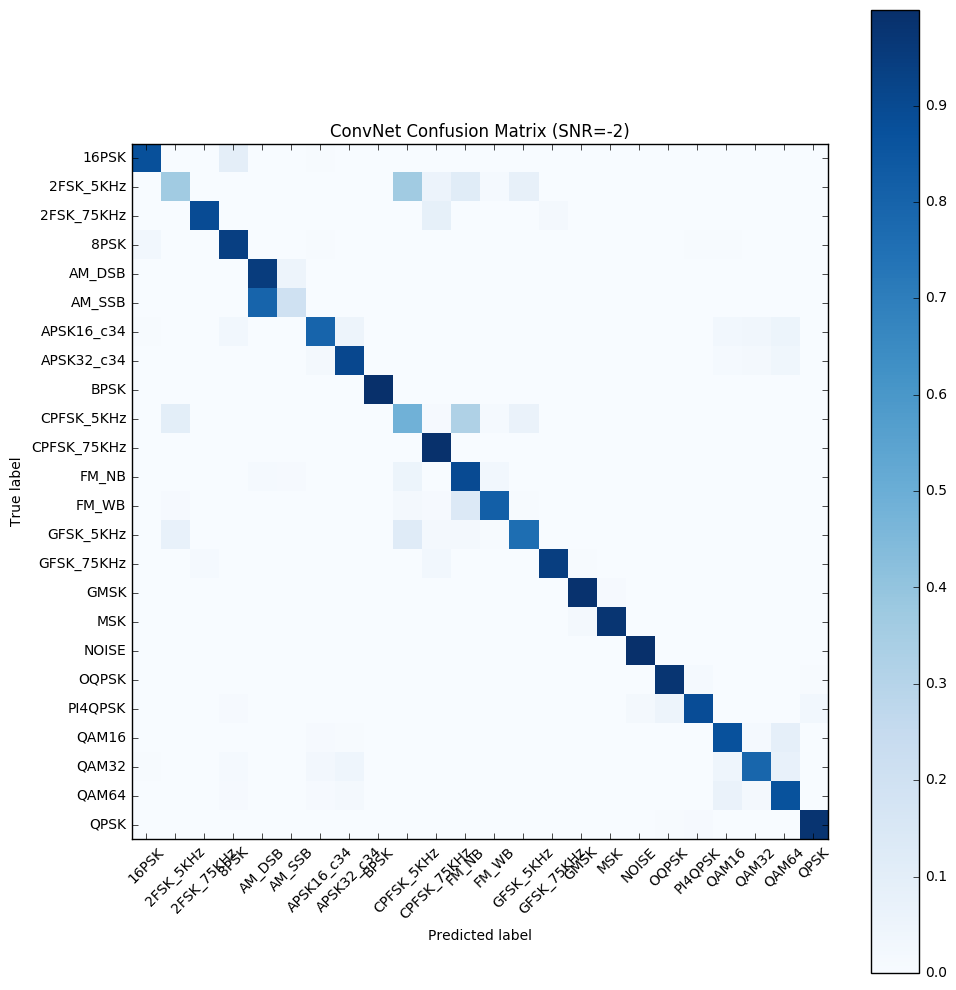

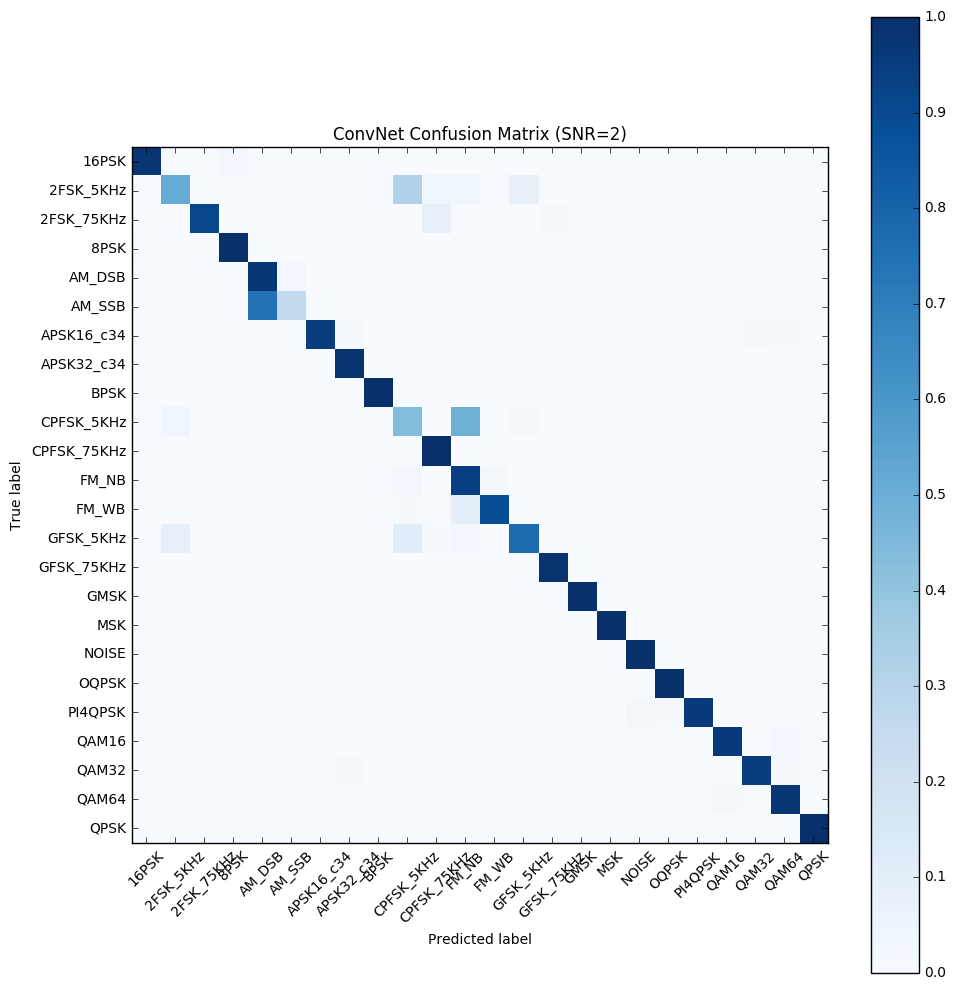

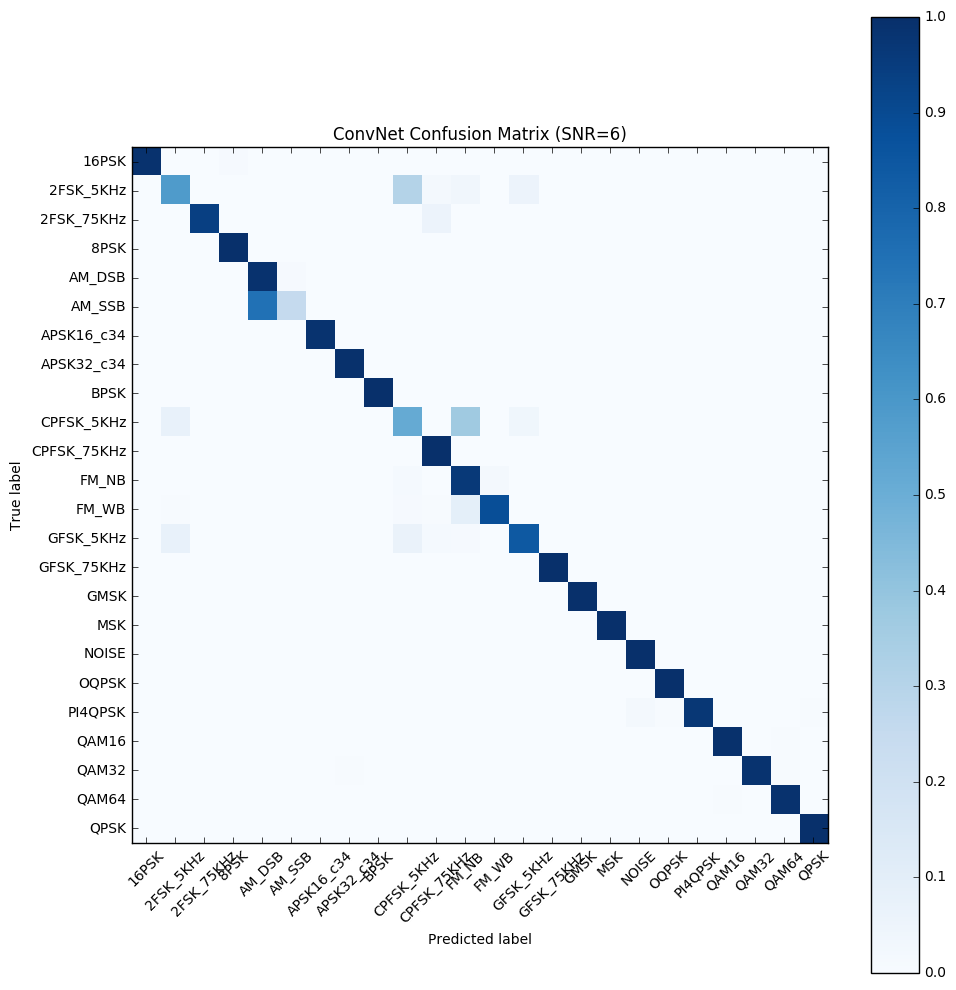

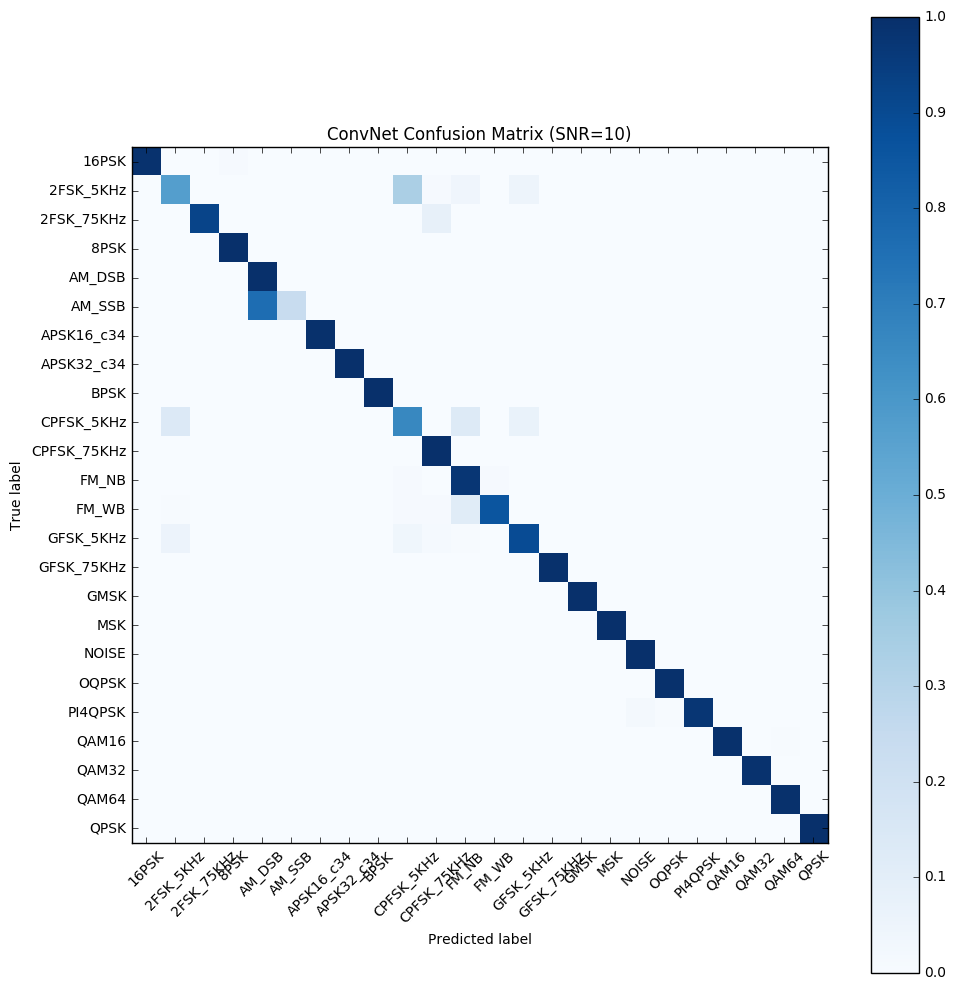

In [6]:
# Plot confusion matrix


acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in testdata.snrValues:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)